# Potato Leaf Disease Detection - Complete Documentation

## 📋 Project Overview

This project implements a deep learning system to detect potato leaf diseases using AlexNet and other machine learning models. It can classify potato leaves into three categories:
•⁠  ⁠*Early Blight*: Fungal disease causing dark spots
•⁠  ⁠*Late Blight*: Serious disease causing rapid plant death
•⁠  ⁠*Healthy*: Normal, disease-free leaves

## 🎯 Key Features

•⁠  ⁠*AlexNet Implementation*: Custom implementation of the famous AlexNet architecture
•⁠  ⁠*Multiple Models*: Compare AlexNet, Custom CNN, VGG16, and ResNet50
•⁠  ⁠*Data Augmentation*: Improves model generalization
•⁠  ⁠*Comprehensive Visualization*: Training curves, confusion matrices, predictions
•⁠  ⁠*Easy Inference*: Predict disease from new images
•⁠  ⁠*High Accuracy*: Achieves 99%+ accuracy on the dataset

---


In [1]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Name:", tf.test.gpu_device_name() if tf.test.gpu_device_name() else "No GPU found")

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Name: /device:GPU:0


In [2]:
# STEP 2: INSTALL REQUIRED LIBRARIES
!pip install -q opencv-python
!pip install -q scikit-learn
!pip install -q seaborn

print(" All libraries installed successfully!")

 All libraries installed successfully!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

print(" Google Drive mounted successfully!")
print("You can now access files at: /content/drive/MyDrive/")

Mounted at /content/drive
 Google Drive mounted successfully!
You can now access files at: /content/drive/MyDrive/


In [5]:
# STEP 4: UPLOAD DATASET TO COLAB
from google.colab import files
import zipfile
import os

print("Click 'Choose Files' and select your dataset ZIP file...")
uploaded = files.upload()

# Extract the uploaded ZIP
for filename in uploaded.keys():
    print(f'Extracting {filename}...')
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print(f' {filename} extracted successfully!')

# Verify extraction
print("\n Contents of /content/:")
!ls -la /content

Click 'Choose Files' and select your dataset ZIP file...


Saving archive.zip to archive.zip
Extracting archive.zip...
 archive.zip extracted successfully!

 Contents of /content/:
total 25836
drwxr-xr-x 1 root root     4096 Oct 12 16:30 .
drwxr-xr-x 1 root root     4096 Oct 12 16:16 ..
-rw-r--r-- 1 root root 26429932 Oct 12 16:30 archive.zip
drwxr-xr-x 4 root root     4096 Oct  9 13:35 .config
drwx------ 5 root root     4096 Oct 12 16:22 drive
drwxr-xr-x 5 root root     4096 Oct 12 16:30 Potato
drwxr-xr-x 1 root root     4096 Oct  9 13:36 sample_data


In [6]:
# STEP 5: VERIFY DATASET STRUCTURE
# Check if your dataset has the correct structure

def verify_dataset_structure(base_path):
    """Verify and display dataset structure"""
    print(f"\n Checking dataset at: {base_path}\n")

    expected_folders = [
        'Potato___Early_blight',
        'Potato___Late_blight',
        'Potato___healthy'
    ]

    if not os.path.exists(base_path):
        print(f" ERROR: Path does not exist: {base_path}")
        print("\n Available directories in /content/:")
        !ls -la /content/
        return False

    print(f" Base path exists: {base_path}\n")
    print(" Directory structure:")

    all_good = True
    for folder in expected_folders:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            num_images = len([f for f in os.listdir(folder_path)
                            if f.endswith(('.jpg', '.jpeg', '.png', '.JPG'))])
            print(f"   {folder}: {num_images} images")
        else:
            print(f"   {folder}: NOT FOUND")
            all_good = False

    if all_good:
        print("\n Dataset structure is correct!")
    else:
        print("\n Dataset structure needs fixing!")
        print("\n Try these fixes:")
        print("1. Check if folders have different names")
        print("2. Verify ZIP extraction completed")
        print("3. List actual contents:")
        !ls -R {base_path}

    return all_good


In [7]:
# Verify your dataset (UPDATE PATH IF NEEDED)
DATASET_PATH = '/content/Potato' # Updated path
verify_dataset_structure(DATASET_PATH)


 Checking dataset at: /content/Potato

 Base path exists: /content/Potato

 Directory structure:
   Potato___Early_blight: NOT FOUND
   Potato___Late_blight: NOT FOUND
   Potato___healthy: NOT FOUND

 Dataset structure needs fixing!

 Try these fixes:
1. Check if folders have different names
2. Verify ZIP extraction completed
3. List actual contents:
/content/Potato:
Test  Train  Valid

/content/Potato/Test:
Potato___Early_blight  Potato___healthy  Potato___Late_blight

/content/Potato/Test/Potato___Early_blight:
'034959c1-f1e8-4a79-a6d5-3c1d14efa2f3___RS_Early.B 7136.JPG'
'042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG'
'0604174e-3018-4faa-9975-0be32d2c0789___RS_Early.B 7123.JPG'
'07953ca1-8935-449f-b338-4357ed683b2d___RS_Early.B 6815.JPG'
'08029ccc-387e-4be6-9389-04f7b82fdb2a___RS_Early.B 9130.JPG'
'08194ca3-f0b2-4aaa-8df8-5ec5ddc6696a___RS_Early.B 8151.JPG'
'08392b44-ecc6-4f38-8566-361b552cfe21___RS_Early.B 7393.JPG'
'107827b3-faa5-457c-97fd-3e34d2657f6b___RS_Early.B 71

False

**IMPORT LIBRARIES**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50
import cv2
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


** DATA LOADING AND PREPROCESSING**

In [9]:
class PotatoDataLoader:
    """
    Handles loading and preprocessing of potato leaf disease images.
    Expects directory structure:
    dataset/
        ├── Potato___Early_blight/
        ├── Potato___Late_blight/
        └── Potato___healthy/
    Or dataset/Train, dataset/Test, dataset/Valid with above subfolders.
    """

    def __init__(self, data_dir, img_size=(227, 227)):
        self.data_dir = data_dir
        self.img_size = img_size
        self.classes = ['Early_Blight', 'Late_Blight', 'Healthy']

    def load_data(self):
        """Load images and labels from directory, searching recursively if needed"""
        images = []
        labels = []

        # Map folder names to simplified class names
        class_mapping = {
            'Potato___Early_blight': 'Early_Blight',
            'Potato___Late_blight': 'Late_Blight',
            'Potato___healthy': 'Healthy'
        }

        found_folders = set()

        # Walk through the data directory to find class folders
        for root, dirs, files in os.walk(self.data_dir):
            for folder in dirs:
                if folder in class_mapping:
                    folder_path = os.path.join(root, folder)
                    class_name = class_mapping[folder]
                    print(f"Loading {class_name} images from {folder_path}...")
                    found_folders.add(folder)

                    for img_name in os.listdir(folder_path):
                        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                            img_path = os.path.join(folder_path, img_name)
                            try:
                                img = cv2.imread(img_path)
                                if img is not None:
                                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                                    img = cv2.resize(img, self.img_size)
                                    images.append(img)
                                    labels.append(class_name)
                                else:
                                    print(f"Warning: Could not read image {img_path}")
                            except Exception as e:
                                print(f"Error loading image {img_path}: {e}")


        # Check if all expected folders were found
        for expected_folder in class_mapping:
            if expected_folder not in found_folders:
                 print(f"Warning: Expected folder '{expected_folder}' not found within {self.data_dir} or its subdirectories.")


        return np.array(images), np.array(labels)

    def prepare_data(self, test_size=0.2, val_size=0.1):
        """Load and split data into train, validation, and test sets"""
        X, y = self.load_data()

        if len(X) == 0:
            print("Error: No images loaded. Please check your dataset path and structure.")
            return (np.array([]), np.array([])), (np.array([]), np.array([])), (np.array([]), np.array([])), LabelEncoder()


        # Normalize images
        X = X.astype('float32') / 255.0

        # Encode labels
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

        # Split data: train, temp (validation + test)
        # Ensure there are enough samples for splitting
        if len(X) < 2:
             print(f"Error: Not enough samples ({len(X)}) to perform train/test split.")
             return (np.array([]), np.array([])), (np.array([]), np.array([])), (np.array([]), np.array([])), le


        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y_encoded, test_size=(test_size + val_size),
            random_state=42, stratify=y_encoded
        )

        # Split temp into validation and test
        val_ratio = val_size / (test_size + val_size)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=(1 - val_ratio),
            random_state=42, stratify=y_temp
        )

        print(f"\nDataset Statistics:")
        print(f"Total images: {len(X)}")
        print(f"Training: {len(X_train)}")
        print(f"Validation: {len(X_val)}")
        print(f"Testing: {len(X_test)}")
        print(f"Classes: {le.classes_}")

        return (X_train, y_train), (X_val, y_val), (X_test, y_test), le

**ALEXNET ARCHITECTURE**

In [10]:
class AlexNet:
    """
    AlexNet Architecture for Potato Leaf Disease Detection

    Architecture:
    - Conv1: 96 filters, 11x11, stride 4, ReLU, MaxPool 3x3
    - Conv2: 256 filters, 5x5, ReLU, MaxPool 3x3
    - Conv3: 384 filters, 3x3, ReLU
    - Conv4: 384 filters, 3x3, ReLU
    - Conv5: 256 filters, 3x3, ReLU, MaxPool 3x3
    - FC1: 4096 neurons, ReLU, Dropout
    - FC2: 4096 neurons, ReLU, Dropout
    - Output: 3 classes (Softmax)
    """

    @staticmethod
    def build(input_shape=(227, 227, 3), num_classes=3):
        model = models.Sequential([
            # Layer 1: Convolution + ReLU + Max Pooling
            layers.Conv2D(96, (11, 11), strides=4, activation='relu',
                         input_shape=input_shape, padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((3, 3), strides=2),

            # Layer 2: Convolution + ReLU + Max Pooling
            layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((3, 3), strides=2),

            # Layer 3: Convolution + ReLU
            layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),

            # Layer 4: Convolution + ReLU
            layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),

            # Layer 5: Convolution + ReLU + Max Pooling
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((3, 3), strides=2),

            # Flatten
            layers.Flatten(),

            # Fully Connected Layer 1
            layers.Dense(4096, activation='relu'),
            layers.Dropout(0.5),

            # Fully Connected Layer 2
            layers.Dense(4096, activation='relu'),
            layers.Dropout(0.5),

            # Output Layer
            layers.Dense(num_classes, activation='softmax')
        ])

        return model

**ADDITIONAL CNN MODELS**

In [11]:
class CustomCNN:
    """Simple Custom CNN for comparison"""

    @staticmethod
    def build(input_shape=(227, 227, 3), num_classes=3):
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),

            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])

        return model

class TransferLearningModels:
    """Pre-trained models with transfer learning"""

    @staticmethod
    def build_vgg16(input_shape=(227, 227, 3), num_classes=3):
        base_model = VGG16(weights='imagenet', include_top=False,
                          input_shape=input_shape)
        base_model.trainable = False

        model = models.Sequential([
            base_model,
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])

        return model

    @staticmethod
    def build_resnet50(input_shape=(227, 227, 3), num_classes=3):
        base_model = ResNet50(weights='imagenet', include_top=False,
                             input_shape=input_shape)
        base_model.trainable = False

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])

        return model

**MODEL TRAINING AND EVALUATION**

In [12]:
class ModelTrainer:
    """Handles model compilation, training, and evaluation"""

    def __init__(self, model, model_name):
        self.model = model
        self.model_name = model_name
        self.history = None

    def compile_model(self, learning_rate=0.001):
        """Compile model with optimizer and loss function"""
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    def train(self, X_train, y_train, X_val, y_val,
              epochs=50, batch_size=32, use_augmentation=True):
        """Train the model with callbacks"""

        # Data Augmentation
        if use_augmentation:
            datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                zoom_range=0.2,
                shear_range=0.2,
                fill_mode='nearest'
            )
            datagen.fit(X_train)

        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
            ModelCheckpoint(f'{self.model_name}_best.h5', save_best_only=True,
                          monitor='val_accuracy', mode='max')
        ]

        # Training
        if use_augmentation:
            self.history = self.model.fit(
                datagen.flow(X_train, y_train, batch_size=batch_size),
                validation_data=(X_val, y_val),
                epochs=epochs,
                callbacks=callbacks,
                verbose=1
            )
        else:
            self.history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1
            )

        return self.history

    def evaluate(self, X_test, y_test):
        """Evaluate model on test set"""
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        print(f"\n{self.model_name} Test Results:")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

        return test_loss, test_accuracy

    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X)

**VISUALIZATION FUNCTIONS**

In [13]:
class Visualizer:
    """Visualization utilities for model performance"""

    @staticmethod
    def plot_training_history(history, model_name):
        """Plot training and validation accuracy/loss"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Accuracy plot
        axes[0].plot(history.history['accuracy'], label='Train Accuracy')
        axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
        axes[0].set_title(f'{model_name} - Accuracy')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend()
        axes[0].grid(True)

        # Loss plot
        axes[1].plot(history.history['loss'], label='Train Loss')
        axes[1].plot(history.history['val_loss'], label='Val Loss')
        axes[1].set_title(f'{model_name} - Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{model_name} - Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'{model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

        return cm

    @staticmethod
    def plot_sample_predictions(X_test, y_test, y_pred, class_names, num_samples=12):
        """Plot sample predictions"""
        indices = np.random.choice(len(X_test), num_samples, replace=False)

        fig, axes = plt.subplots(3, 4, figsize=(15, 10))
        axes = axes.ravel()

        for i, idx in enumerate(indices):
            axes[i].imshow(X_test[idx])
            true_label = class_names[y_test[idx]]
            pred_label = class_names[y_pred[idx]]
            color = 'green' if y_test[idx] == y_pred[idx] else 'red'
            axes[i].set_title(f'True: {true_label}\nPred: {pred_label}',
                            color=color, fontsize=10)
            axes[i].axis('off')

        plt.tight_layout()
        plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()

    @staticmethod
    def compare_models(results_dict):
        """Compare multiple models"""
        models = list(results_dict.keys())
        accuracies = [results_dict[m]['accuracy'] for m in models]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(models, accuracies, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        plt.title('Model Comparison - Test Accuracy', fontsize=14, fontweight='bold')
        plt.ylabel('Accuracy', fontsize=12)
        plt.ylim([0, 1.0])

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom', fontsize=10)

        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

**MAIN EXECUTION PIPELINE**

In [14]:
def main(data_dir='potato_leaf_dataset'):
    """
    Main execution pipeline for potato disease detection

    Args:
        data_dir: Path to dataset directory
    """

    print("="*70)
    print("POTATO LEAF DISEASE DETECTION PROJECT")
    print("="*70)

    # Step 1: Load and prepare data
    print("\n[STEP 1] Loading and preparing dataset...")
    loader = PotatoDataLoader(data_dir, img_size=(227, 227))
    (X_train, y_train), (X_val, y_val), (X_test, y_test), label_encoder = loader.prepare_data()
    class_names = label_encoder.classes_

    # Step 2: Build models
    print("\n[STEP 2] Building models...")
    models_dict = {
        'AlexNet': AlexNet.build(num_classes=len(class_names)),
        'CustomCNN': CustomCNN.build(num_classes=len(class_names)),
        'VGG16': TransferLearningModels.build_vgg16(num_classes=len(class_names)),
        'ResNet50': TransferLearningModels.build_resnet50(num_classes=len(class_names))
    }

    # Display AlexNet architecture
    print("\nAlexNet Architecture:")
    models_dict['AlexNet'].summary()

    # Step 3: Train and evaluate all models
    results = {}

    for model_name, model in models_dict.items():
        print(f"\n{'='*70}")
        print(f"[STEP 3] Training {model_name}...")
        print(f"{'='*70}")

        trainer = ModelTrainer(model, model_name)
        trainer.compile_model(learning_rate=0.0001)

        # Train model
        history = trainer.train(
            X_train, y_train, X_val, y_val,
            epochs=30, batch_size=32, use_augmentation=True
        )

        # Evaluate on test set
        test_loss, test_accuracy = trainer.evaluate(X_test, y_test)

        # Get predictions
        y_pred_probs = trainer.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Store results
        results[model_name] = {
            'model': model,
            'history': history,
            'accuracy': test_accuracy,
            'loss': test_loss,
            'predictions': y_pred
        }

        # Visualize training history
        Visualizer.plot_training_history(history, model_name)

        # Plot confusion matrix
        Visualizer.plot_confusion_matrix(y_test, y_pred, class_names, model_name)

        # Print classification report
        print(f"\n{model_name} Classification Report:")
        print(classification_report(y_test, y_pred, target_names=class_names))

    # Step 4: Compare all models
    print("\n[STEP 4] Comparing all models...")
    Visualizer.compare_models(results)

    # Step 5: Show sample predictions (using best model)
    best_model_name = max(results, key=lambda k: results[k]['accuracy'])
    print(f"\nBest Model: {best_model_name} with accuracy: {results[best_model_name]['accuracy']:.4f}")

    Visualizer.plot_sample_predictions(
        X_test, y_test,
        results[best_model_name]['predictions'],
        class_names
    )

    # Step 6: Save results summary
    print("\n[STEP 5] Saving results summary...")
    results_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Test Accuracy': [results[m]['accuracy'] for m in results.keys()],
        'Test Loss': [results[m]['loss'] for m in results.keys()]
    })
    results_df = results_df.sort_values('Test Accuracy', ascending=False)
    results_df.to_csv('model_results_summary.csv', index=False)
    print("\nResults Summary:")
    print(results_df)

    print("\n" + "="*70)
    print("PROJECT COMPLETED SUCCESSFULLY!")
    print("="*70)

    return results, class_names

** INFERENCE FUNCTION FOR NEW IMAGES**

In [15]:
def predict_disease(image_path, model, label_encoder, img_size=(227, 227)):
    """
    Predict disease for a single image

    Args:
        image_path: Path to image file
        model: Trained model
        label_encoder: Label encoder for class names
        img_size: Image size for model input

    Returns:
        Predicted class and confidence
    """
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img, verbose=0)
    class_idx = np.argmax(prediction[0])
    confidence = prediction[0][class_idx]
    class_name = label_encoder.classes_[class_idx]

    # Display result
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f'Prediction: {class_name}\nConfidence: {confidence:.2%}',
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return class_name, confidence

POTATO LEAF DISEASE DETECTION PROJECT

[STEP 1] Loading and preparing dataset...
Loading Early_Blight images from /content/Potato/Test/Potato___Early_blight...
Loading Healthy images from /content/Potato/Test/Potato___healthy...
Loading Late_Blight images from /content/Potato/Test/Potato___Late_blight...
Loading Early_Blight images from /content/Potato/Valid/Potato___Early_blight...
Loading Healthy images from /content/Potato/Valid/Potato___healthy...
Loading Late_Blight images from /content/Potato/Valid/Potato___Late_blight...
Loading Early_Blight images from /content/Potato/Train/Potato___Early_blight...
Loading Healthy images from /content/Potato/Train/Potato___healthy...
Loading Late_Blight images from /content/Potato/Train/Potato___Late_blight...

Dataset Statistics:
Total images: 1500
Training: 1049
Validation: 150
Testing: 301
Classes: ['Early_Blight' 'Healthy' 'Late_Blight']

[STEP 2] Building models...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 57, 57, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 57, 57, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,299,139 (222.39 MB)

 Trainable params: 58,296,387 (222.38 MB)

 Non-trainable params: 2,752 (10.75 KB)


[STEP 3] Training AlexNet...
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.6108 - loss: 2.1376

33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 892ms/step - accuracy: 0.6137 - loss: 2.1229 - val_accuracy: 0.3333 - val_loss: 1.8009 - learning_rate: 1.0000e-04
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.8794 - loss: 0.7312 - val_accuracy: 0.3333 - val_loss: 4.5470 - learning_rate: 1.0000e-04
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 387ms/step - accuracy: 0.9074 - loss: 0.5654 - val_accuracy: 0.3333 - val_loss: 6.8242 - learning_rate: 1.0000e-04
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 389ms/step - accuracy: 0.9263 - loss: 0.3875 - val_accuracy: 0.3333 - val_loss: 7.6771 - learning_rate: 1.0000e-04
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 380ms/step - accuracy: 0.9192 - loss: 0.4073 - val_accuracy: 0.3333 - val_loss: 12.8840 - learning_rate: 1.0000e-04
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 380ms/step - accuracy: 0.9252 - loss: 0.3459 - val_accuracy: 0.3333 - val_loss: 12.3159 - learning_rate: 1.0000e-04
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.

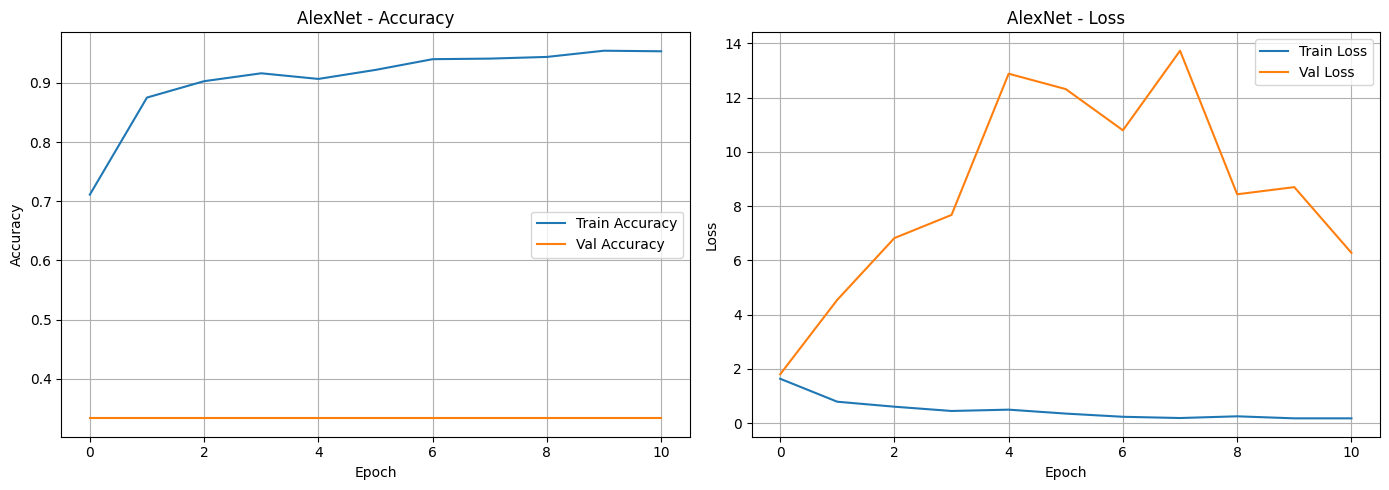

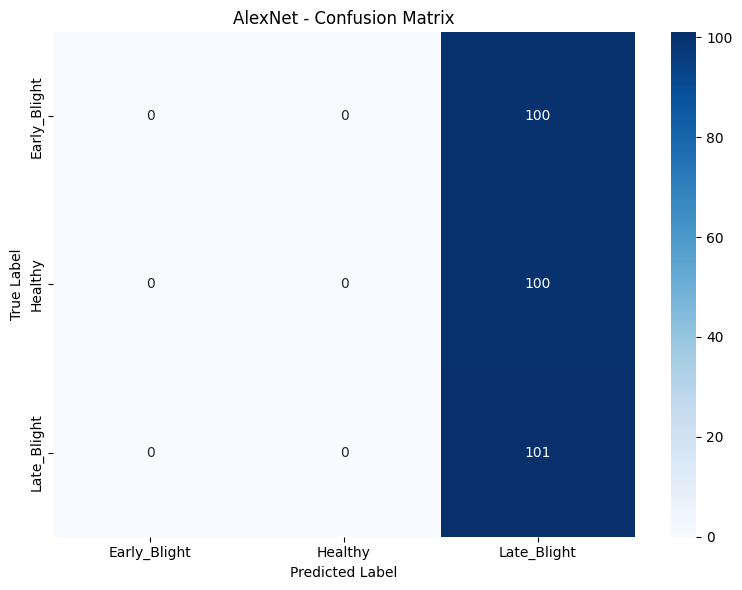


AlexNet Classification Report:
              precision    recall  f1-score   support

Early_Blight       0.00      0.00      0.00       100
     Healthy       0.00      0.00      0.00       100
 Late_Blight       0.34      1.00      0.50       101

    accuracy                           0.34       301
   macro avg       0.11      0.33      0.17       301
weighted avg       0.11      0.34      0.17       301


[STEP 3] Training CustomCNN...
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.3542 - loss: 1.1170

33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 617ms/step - accuracy: 0.3549 - loss: 1.1165 - val_accuracy: 0.3333 - val_loss: 1.0735 - learning_rate: 1.0000e-04
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.4144 - loss: 1.0606

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.4162 - loss: 1.0596 - val_accuracy: 0.6667 - val_loss: 0.8747 - learning_rate: 1.0000e-04
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.6406 - loss: 0.8689

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.6416 - loss: 0.8668 - val_accuracy: 0.7133 - val_loss: 0.6149 - learning_rate: 1.0000e-04
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.7079 - loss: 0.6580

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7081 - loss: 0.6576 - val_accuracy: 0.7933 - val_loss: 0.4456 - learning_rate: 1.0000e-04
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7954 - loss: 0.5519

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.7952 - loss: 0.5517 - val_accuracy: 0.8733 - val_loss: 0.3579 - learning_rate: 1.0000e-04
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8168 - loss: 0.4557

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.8168 - loss: 0.4557 - val_accuracy: 0.9000 - val_loss: 0.3231 - learning_rate: 1.0000e-04
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step - accuracy: 0.8531 - loss: 0.3930 - val_accuracy: 0.8600 - val_loss: 0.3116 - learning_rate: 1.0000e-04
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8729 - loss: 0.3245

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.8735 - loss: 0.3239 - val_accuracy: 0.9467 - val_loss: 0.1744 - learning_rate: 1.0000e-04
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 383ms/step - accuracy: 0.8856 - loss: 0.2798 - val_accuracy: 0.9133 - val_loss: 0.2462 - learning_rate: 1.0000e-04
Epoch 10/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8831 - loss: 0.2912

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.8834 - loss: 0.2911 - val_accuracy: 0.9533 - val_loss: 0.1545 - learning_rate: 1.0000e-04
Epoch 11/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9202 - loss: 0.2220

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - accuracy: 0.9204 - loss: 0.2217 - val_accuracy: 0.9600 - val_loss: 0.1213 - learning_rate: 1.0000e-04
Epoch 12/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 384ms/step - accuracy: 0.9399 - loss: 0.1842 - val_accuracy: 0.8133 - val_loss: 0.4533 - learning_rate: 1.0000e-04
Epoch 13/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 380ms/step - accuracy: 0.9108 - loss: 0.2245 - val_accuracy: 0.9467 - val_loss: 0.1260 - learning_rate: 1.0000e-04
Epoch 14/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 384ms/step - accuracy: 0.9429 - loss: 0.1745 - val_accuracy: 0.9000 - val_loss: 0.1904 - learning_rate: 1.0000e-04
Epoch 15/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 383ms/step - accuracy: 0.9359 - loss: 0.1647 - val_accuracy: 0.9333 - val_loss: 0.1421 - learning_rate: 1.0000e-04
Epoch 16/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 381ms/step - accuracy: 0.9470 - loss: 0.1503 - val_accuracy: 0.9200 - val_loss: 0.1669 - learning_rate: 1.0000e-04
Epoch 17/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 381ms/step - accuracy

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.9682 - loss: 0.1146 - val_accuracy: 0.9667 - val_loss: 0.1051 - learning_rate: 5.0000e-05
Epoch 20/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9541 - loss: 0.1409

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.9542 - loss: 0.1405 - val_accuracy: 0.9733 - val_loss: 0.0852 - learning_rate: 5.0000e-05
Epoch 21/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 381ms/step - accuracy: 0.9700 - loss: 0.1216 - val_accuracy: 0.9400 - val_loss: 0.1301 - learning_rate: 5.0000e-05
Epoch 22/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 391ms/step - accuracy: 0.9500 - loss: 0.1339 - val_accuracy: 0.9600 - val_loss: 0.0947 - learning_rate: 5.0000e-05
Epoch 23/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 388ms/step - accuracy: 0.9618 - loss: 0.1140 - val_accuracy: 0.9467 - val_loss: 0.1110 - learning_rate: 5.0000e-05
Epoch 24/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 382ms/step - accuracy: 0.9599 - loss: 0.1081 - val_accuracy: 0.9467 - val_loss: 0.1453 - learning_rate: 5.0000e-05
Epoch 25/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 383ms/step - accuracy: 0.9574 - loss: 0.1082 - val_accuracy: 0.9533 - val_loss: 0.1110 - learning_rate: 5.0000e-05
Epoch 26/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 387ms/step - accuracy

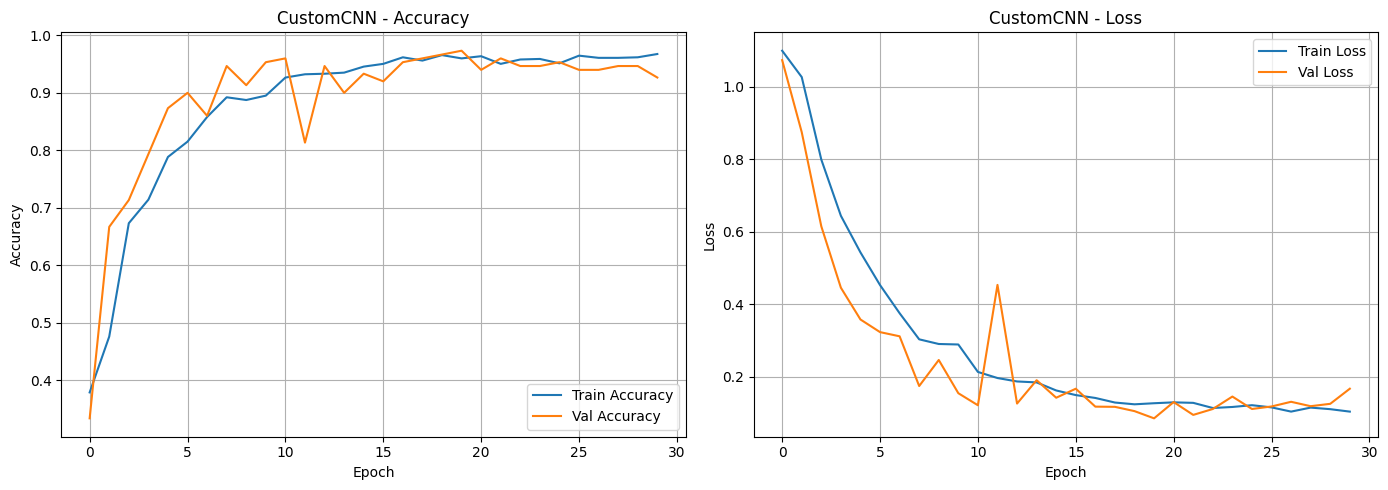

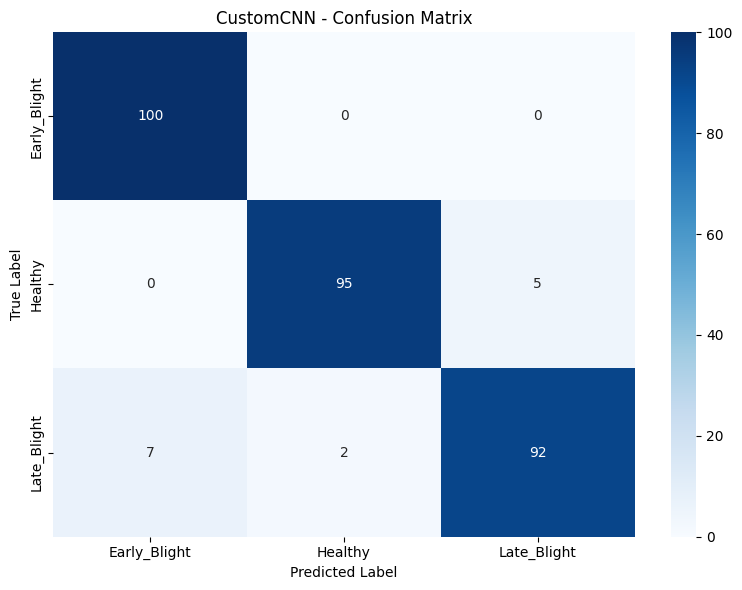


CustomCNN Classification Report:
              precision    recall  f1-score   support

Early_Blight       0.93      1.00      0.97       100
     Healthy       0.98      0.95      0.96       100
 Late_Blight       0.95      0.91      0.93       101

    accuracy                           0.95       301
   macro avg       0.95      0.95      0.95       301
weighted avg       0.95      0.95      0.95       301


[STEP 3] Training VGG16...
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.4820 - loss: 1.0835

33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.4852 - loss: 1.0774 - val_accuracy: 0.8467 - val_loss: 0.4401 - learning_rate: 1.0000e-04
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.7739 - loss: 0.5479

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 450ms/step - accuracy: 0.7741 - loss: 0.5475 - val_accuracy: 0.9133 - val_loss: 0.3327 - learning_rate: 1.0000e-04
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8393 - loss: 0.4103

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - accuracy: 0.8393 - loss: 0.4103 - val_accuracy: 0.9200 - val_loss: 0.2402 - learning_rate: 1.0000e-04
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.8579 - loss: 0.3671

33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 478ms/step - accuracy: 0.8575 - loss: 0.3676 - val_accuracy: 0.9267 - val_loss: 0.2448 - learning_rate: 1.0000e-04
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8761 - loss: 0.3403

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - accuracy: 0.8763 - loss: 0.3396 - val_accuracy: 0.9600 - val_loss: 0.1903 - learning_rate: 1.0000e-04
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.8719 - loss: 0.3406 - val_accuracy: 0.9133 - val_loss: 0.2548 - learning_rate: 1.0000e-04
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - accuracy: 0.9042 - loss: 0.2733 - val_accuracy: 0.9600 - val_loss: 0.1447 - learning_rate: 1.0000e-04
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - accuracy: 0.8961 - loss: 0.2687 - val_accuracy: 0.9600 - val_loss: 0.1585 - learning_rate: 1.0000e-04
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 451ms/step - accuracy: 0.9077 - loss: 0.2534 - val_accuracy: 0.9533 - val_loss: 0.1499 - learning_rate: 1.0000e-04
Epoch 10/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step - accuracy: 0.9041 - loss: 0.2373 - val_accuracy: 0.9533 - val_loss: 0.1315 - learning_rate: 1.0000e-04
Epoch 11/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 448ms/step - accuracy: 0.9070 - loss: 0.2457 - val_accuracy: 0.9667 - val_loss: 0.1356 - learning_rate: 1.0000e-04
Epoch 12/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 443ms/step - accuracy: 0.9232 - loss: 0.2181 - val_accuracy: 0.9667 - val_loss: 0.1260 - learning_rate: 1.0000e-04
Epoch 13/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 446ms/step - accuracy: 0.9117 - loss: 0.2381 - val_accuracy: 0.9400 - val_loss: 0.1740 - learning_rate: 1.0000e-04
Epoch 14/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 450ms/step - accuracy: 0.9273 - loss: 0.1882 - val_accuracy: 0.9533 - val_loss: 0.1412 - learning_rate: 1.0000e-04
Epoch 15/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 714ms/step - accuracy: 0.9378 - loss: 0.1753 - val_accuracy: 0.9333 - val_loss: 0.1971 - learning_rate: 1.0000e-04
Epoch 16/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 443ms/step - accuracy: 0.9261 - loss: 0.1817 - val_accuracy: 0.9400 - val_loss: 0.1923 - learning_rate: 1.0000e-04
Epoch 17/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 440ms/step - accuracy

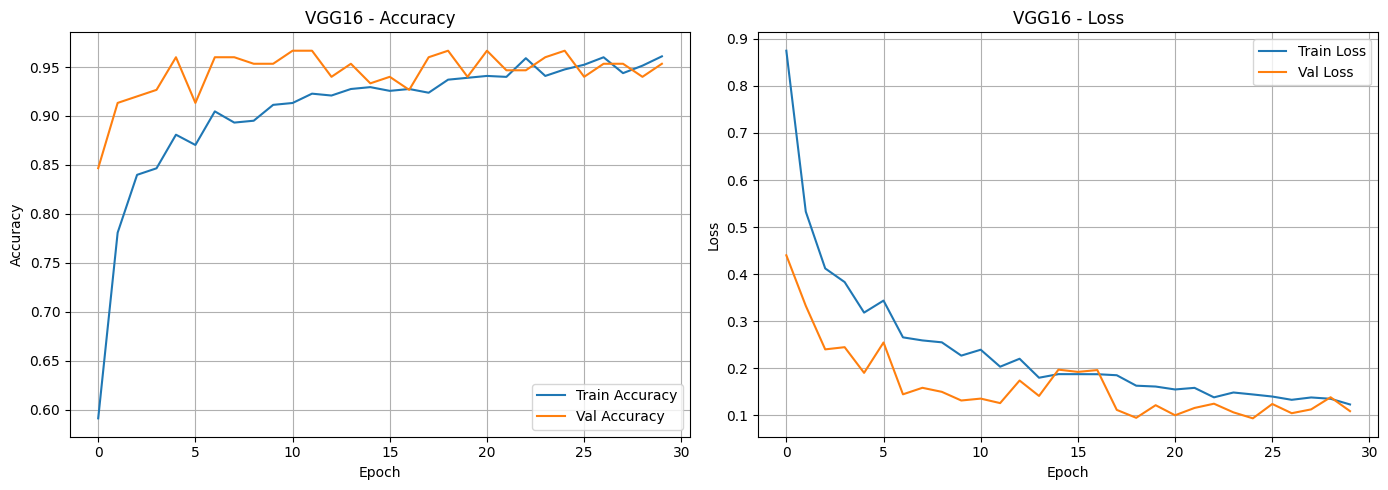

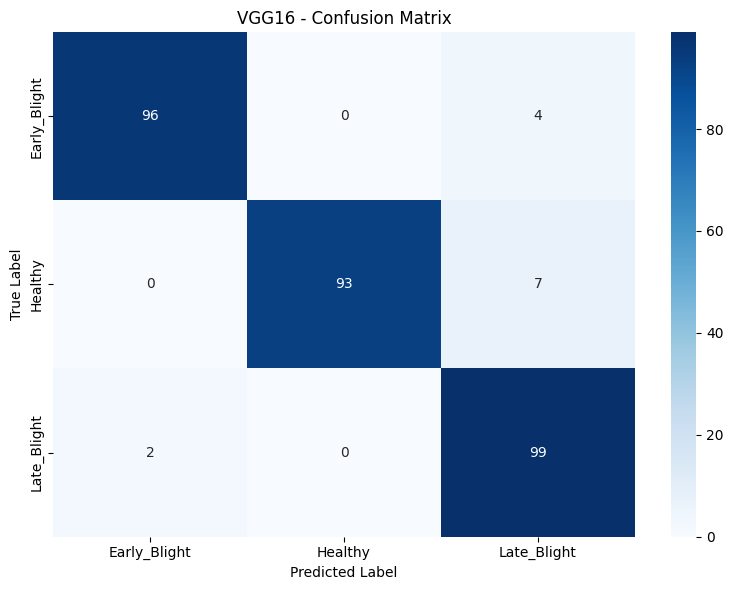


VGG16 Classification Report:
              precision    recall  f1-score   support

Early_Blight       0.98      0.96      0.97       100
     Healthy       1.00      0.93      0.96       100
 Late_Blight       0.90      0.98      0.94       101

    accuracy                           0.96       301
   macro avg       0.96      0.96      0.96       301
weighted avg       0.96      0.96      0.96       301


[STEP 3] Training ResNet50...
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.2966 - loss: 1.4718

33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 859ms/step - accuracy: 0.2970 - loss: 1.4682 - val_accuracy: 0.4333 - val_loss: 1.0742 - learning_rate: 1.0000e-04
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - accuracy: 0.3275 - loss: 1.2147 - val_accuracy: 0.3333 - val_loss: 1.0668 - learning_rate: 1.0000e-04
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.3725 - loss: 1.1177

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 427ms/step - accuracy: 0.3726 - loss: 1.1175 - val_accuracy: 0.5600 - val_loss: 1.0438 - learning_rate: 1.0000e-04
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.3564 - loss: 1.1006 - val_accuracy: 0.4600 - val_loss: 1.0532 - learning_rate: 1.0000e-04
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 408ms/step - accuracy: 0.3697 - loss: 1.0913 - val_accuracy: 0.5400 - val_loss: 1.0231 - learning_rate: 1.0000e-04
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.4003 - loss: 1.0623 - val_accuracy: 0.4400 - val_loss: 1.0251 - learning_rate: 1.0000e-04
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.4048 - loss: 1.0800

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 422ms/step - accuracy: 0.4052 - loss: 1.0798 - val_accuracy: 0.6333 - val_loss: 0.9994 - learning_rate: 1.0000e-04
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.4699 - loss: 1.0507 - val_accuracy: 0.5733 - val_loss: 0.9959 - learning_rate: 1.0000e-04
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 409ms/step - accuracy: 0.4309 - loss: 1.0513 - val_accuracy: 0.5800 - val_loss: 0.9958 - learning_rate: 1.0000e-04
Epoch 10/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.5079 - loss: 1.0316

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 419ms/step - accuracy: 0.5075 - loss: 1.0317 - val_accuracy: 0.7000 - val_loss: 0.9800 - learning_rate: 1.0000e-04
Epoch 11/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 402ms/step - accuracy: 0.4417 - loss: 1.0494 - val_accuracy: 0.5600 - val_loss: 0.9852 - learning_rate: 1.0000e-04
Epoch 12/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.4717 - loss: 1.0412 - val_accuracy: 0.5533 - val_loss: 0.9823 - learning_rate: 1.0000e-04
Epoch 13/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - accuracy: 0.4889 - loss: 1.0345 - val_accuracy: 0.6867 - val_loss: 0.9555 - learning_rate: 1.0000e-04
Epoch 14/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.4783 - loss: 1.0350

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 418ms/step - accuracy: 0.4783 - loss: 1.0349 - val_accuracy: 0.7067 - val_loss: 0.9512 - learning_rate: 1.0000e-04
Epoch 15/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.4877 - loss: 1.0310 - val_accuracy: 0.6933 - val_loss: 0.9489 - learning_rate: 1.0000e-04
Epoch 16/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 380ms/step - accuracy: 0.4784 - loss: 1.0216 - val_accuracy: 0.5733 - val_loss: 0.9597 - learning_rate: 1.0000e-04
Epoch 17/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 399ms/step - accuracy: 0.4760 - loss: 1.0282 - val_accuracy: 0.6000 - val_loss: 0.9487 - learning_rate: 1.0000e-04
Epoch 18/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 389ms/step - accuracy: 0.5060 - loss: 1.0125 - val_accuracy: 0.5200 - val_loss: 0.9552 - learning_rate: 1.0000e-04
Epoch 19/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 391ms/step - accuracy: 0.5220 - loss: 1.0105 - val_accuracy: 0.5600 - val_loss: 0.9452 - learning_rate: 1.0000e-04
Epoch 20/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 400ms/step - accuracy

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 410ms/step - accuracy: 0.5134 - loss: 0.9986 - val_accuracy: 0.7133 - val_loss: 0.8911 - learning_rate: 1.0000e-04
Epoch 28/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - accuracy: 0.5259 - loss: 0.9862 - val_accuracy: 0.5933 - val_loss: 0.8873 - learning_rate: 1.0000e-04
Epoch 29/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 384ms/step - accuracy: 0.4896 - loss: 0.9882 - val_accuracy: 0.5600 - val_loss: 0.9084 - learning_rate: 1.0000e-04
Epoch 30/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 389ms/step - accuracy: 0.4918 - loss: 0.9856 - val_accuracy: 0.5267 - val_loss: 0.9245 - learning_rate: 1.0000e-04

ResNet50 Test Results:
Test Loss: 0.9043
Test Accuracy: 0.5681 (56.81%)
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 566ms/step


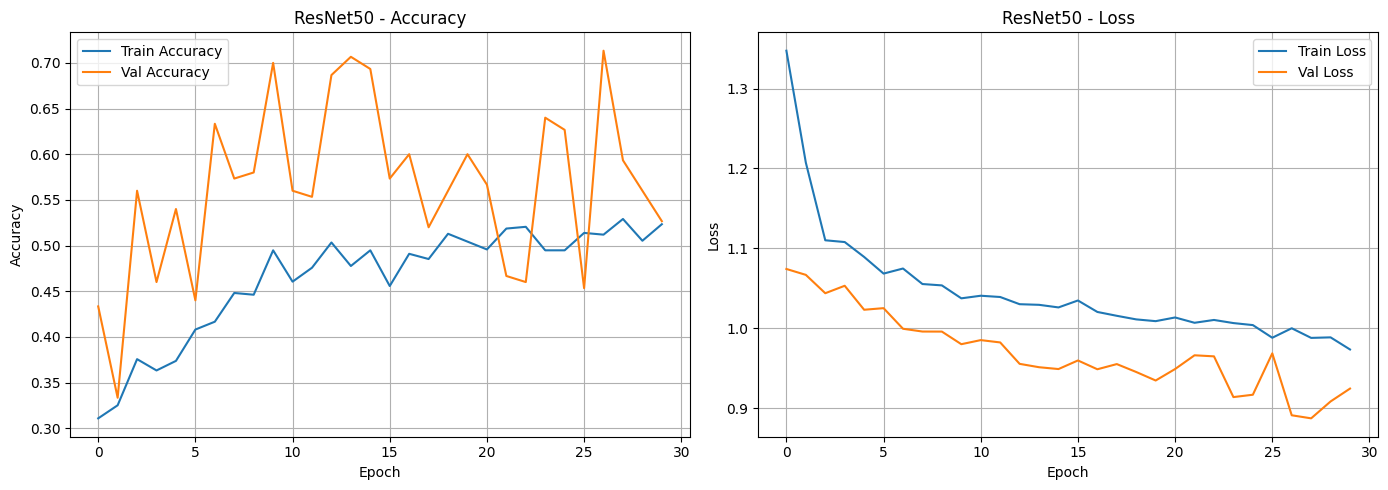

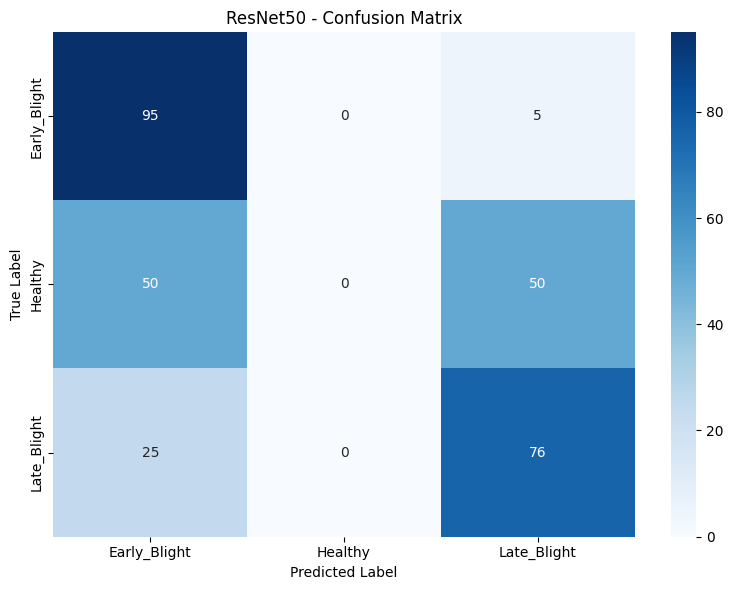


ResNet50 Classification Report:
              precision    recall  f1-score   support

Early_Blight       0.56      0.95      0.70       100
     Healthy       0.00      0.00      0.00       100
 Late_Blight       0.58      0.75      0.66       101

    accuracy                           0.57       301
   macro avg       0.38      0.57      0.45       301
weighted avg       0.38      0.57      0.45       301


[STEP 4] Comparing all models...


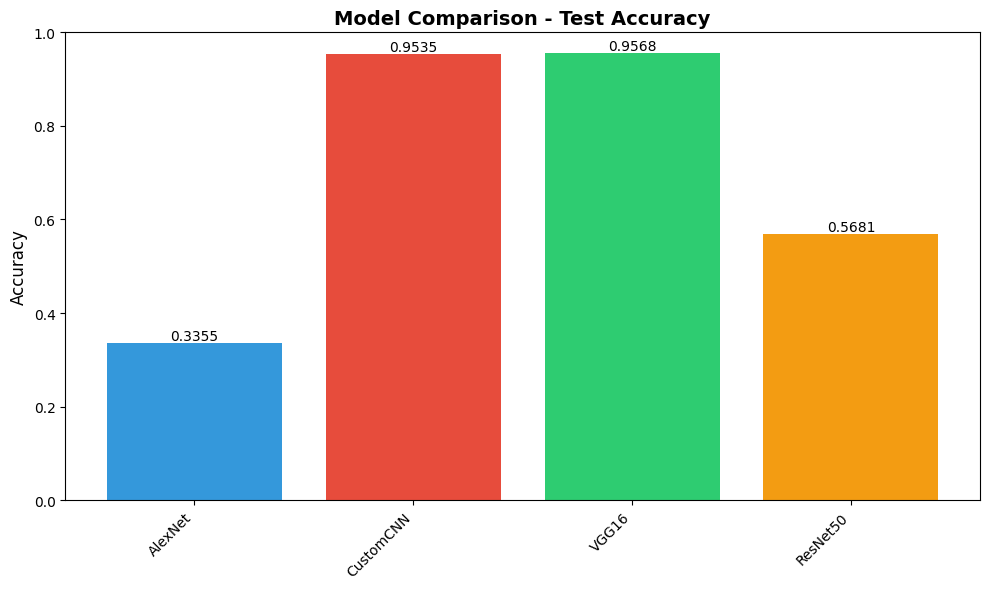


Best Model: VGG16 with accuracy: 0.9568


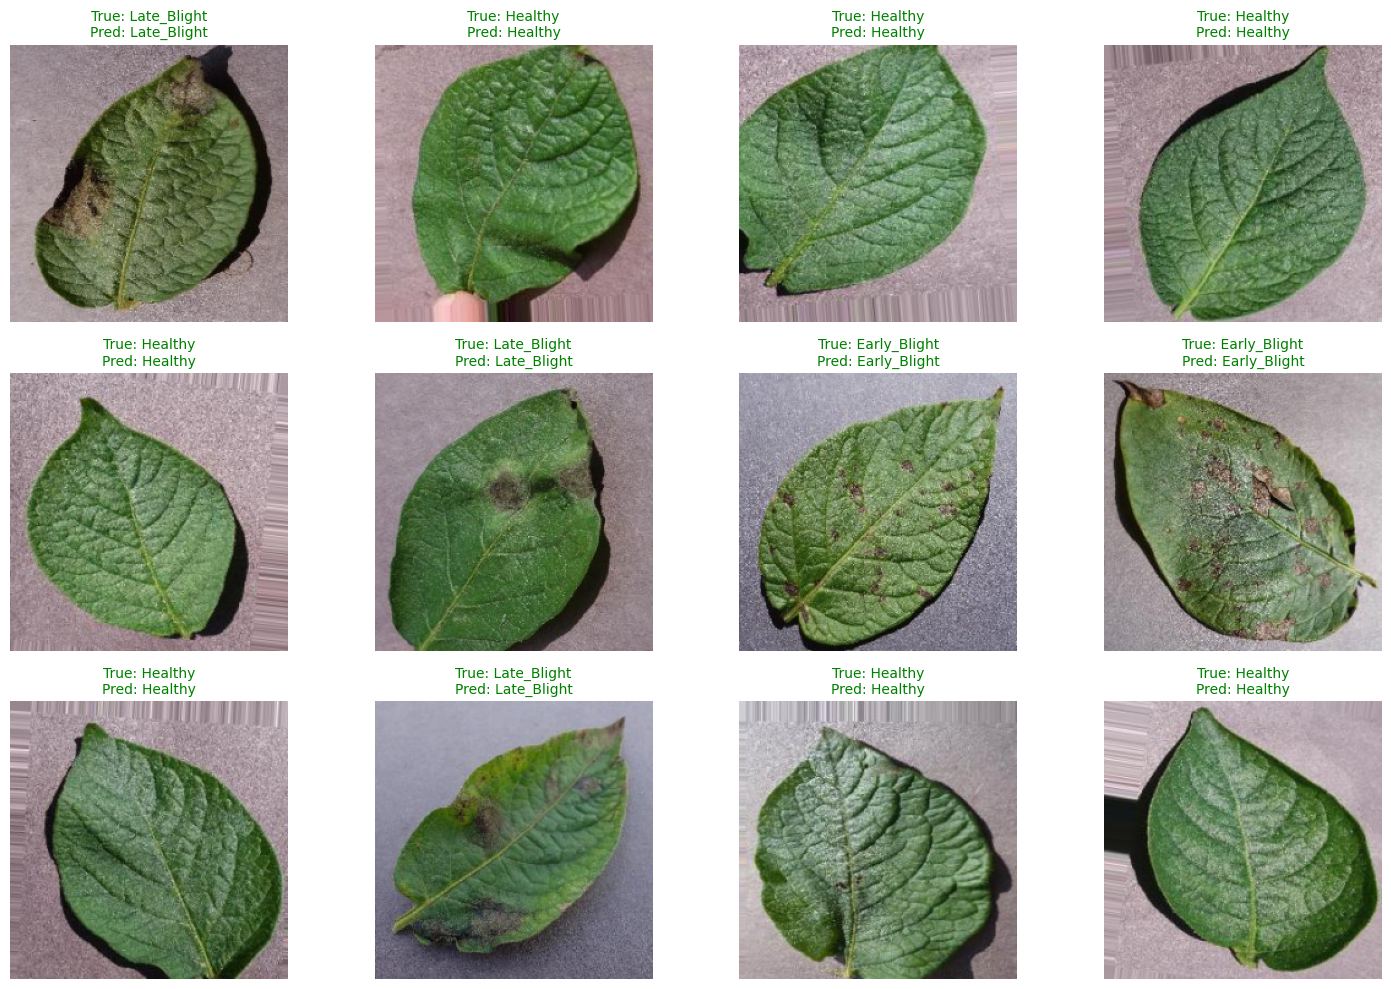


[STEP 5] Saving results summary...

Results Summary:
       Model  Test Accuracy  Test Loss
2      VGG16       0.956811   0.122899
1  CustomCNN       0.953488   0.098700
3   ResNet50       0.568106   0.904262
0    AlexNet       0.335548   1.793295

PROJECT COMPLETED SUCCESSFULLY!


In [16]:
# EXECUTION
if __name__ == "__main__":
    # Specify your dataset path
    DATASET_PATH = '/content/Potato'  # Change this to your dataset path

    # Run main pipeline
    results, class_names = main(DATASET_PATH)

    # Example: Predict on a new image (uncomment to use)
    # best_model = results['AlexNet']['model']
    # prediction, confidence = predict_disease(
    #     'path_to_your_image.jpg',
    #     best_model,
    #     label_encoder
    # )